In [1]:
!pip install sagemaker --upgrade -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
# SageMaker setup
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket='dc-ds-ali-playground')
bucket = sess.default_bucket()

In [3]:
# imports
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms

This is a custom Dataset object images should be placed in seprate folder based on train val test in eacch folder should be a file called label.csv that has two column:
<br>
1-image path
2-image label

In [4]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, annotations_file_name='label.csv', transform=None, target_transform=None):
        self.img_labels = pd.read_csv(os.path.join(img_dir, annotations_file_name))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Make dataset objects and transformations

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation

from torchvision import transforms

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


train_data = CustomImageDataset('../Binary-CNN/train', annotations_file_name='label.csv', transform=data_transforms['train'], target_transform=None)
val_data = CustomImageDataset('../Binary-CNN/val', annotations_file_name='label.csv', transform=data_transforms['val'], target_transform=None)

In [6]:
# make dataloader objects
from torch.utils.data import DataLoader

batch_size = 4

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Let us show some of the training images, for fun.



In [14]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
print(images[0].shape)
print(net(images[0]))

torch.Size([3, 224, 224])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 3, 3, 3], but got 3-dimensional input of size [3, 224, 224] instead

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


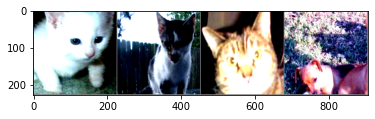

  cat   cat   cat   dog


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
classes =   {0:'cat',
             1:'dog'}

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j].item()] for j in range(batch_size)))

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a CNN

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    
net = Net().to(device)
print(net)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [10]:
import torch.optim as optim

# should be changed for multiclass to cross entropy

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = net.parameters(), lr=0.001)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [13]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 0.692
[1,  1000] loss: 0.690
[1,  1500] loss: 0.677
[1,  2000] loss: 0.671
[1,  2500] loss: 0.650
[1,  3000] loss: 0.662
[1,  3500] loss: 0.658
[1,  4000] loss: 0.664
[1,  4500] loss: 0.645
[1,  5000] loss: 0.638
Finished Training


In [28]:
cr = nn.CrossEntropyLoss()
output = torch.Tensor([[-2.2883, 0.3593],])
label = torch.Tensor([1,]).long()
cr(output, label)

tensor(0.0684)

In [21]:
for i, data in enumerate(train_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data[0].to(device), data[1].to(device)
                    
                    net.eval()
                    # forward
                    output = net(inputs.float()) 
                    print(output)
                    print(labels)
                    print(cr(output, labels))
                    break

tensor([[-2.2883, -3.3593],
        [-0.4603,  0.1768],
        [-1.8707, -2.5515],
        [-1.9477, -2.7005]], grad_fn=<AddmmBackward>)
tensor([1, 1, 0, 0])
tensor(0.6464, grad_fn=<NllLossBackward>)


In [ ]:
loss_history_dict = {'train':[],
                     'val':[]}

dataloaders = {'train':train_dataloader,
               'val':val_dataloader}

for epoch in range(5):  # loop over the dataset multiple times
      
    for phase in ['train', 'val']:
                if phase == 'train':
                    net.train()  # Set model to training mode
                else:
                    net.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                for i, data in enumerate(train_dataloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = data[0].to(device), data[1].to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = net(inputs.float())
                    loss = criterion(outputs, labels.float().unsqueeze(1))
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # print statistics
                    running_loss += loss.item()

                    if i % 500 == 499:   # print every 500 mini-batches
                        avg_loss = running_loss / 500
                        loss_history_dict[phase].append(avg_loss)
                        print(f'[{epoch+1}, {i+1}] {phase} loss: {avg_loss}')
                        running_loss = 0.0

[1, 500] train loss: 0.6843258529901505
[1, 1000] train loss: 0.6747863016724587
[1, 1500] train loss: 0.6751416776180267
[1, 2000] train loss: 0.6650951710939408
[1, 2500] train loss: 0.6617163375020028
[1, 3000] train loss: 0.6584215648174286
[1, 3500] train loss: 0.6530092372298241
[1, 4000] train loss: 0.6477584029436112
[1, 4500] train loss: 0.6406537778377533
[1, 5000] train loss: 0.636503319144249
[1, 500] val loss: 0.6247599501609802
[1, 1000] val loss: 0.6205480927824975
[1, 1500] val loss: 0.6168309974670411
[1, 2000] val loss: 0.6155133103132248
[1, 2500] val loss: 0.6211041677594185
[1, 3000] val loss: 0.6207481665015221
[1, 3500] val loss: 0.6335047392249107
[1, 4000] val loss: 0.6231076962351799
[1, 4500] val loss: 0.6060169878602027
[1, 5000] val loss: 0.6158574367165566
[2, 500] train loss: 0.6296893898844719
[2, 1000] train loss: 0.626760632455349
[2, 1500] train loss: 0.6160038633942604
[2, 2000] train loss: 0.6074142448306084
[2, 2500] train loss: 0.6306223049163818


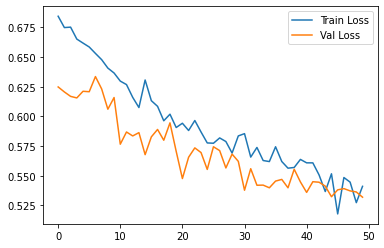

In [38]:
import matplotlib.pyplot as plt
plt.plot(range(50), loss_history_dict['train'], label='Train Loss')
plt.plot(range(50), loss_history_dict['val'], label='Val Loss')

plt.legend()

In [40]:
PATH = './cat_dog_net.pth'
torch.save(net.state_dict(), PATH)

## See the Validation Prediction 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


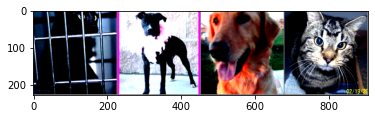

GroundTruth:    cat   dog   dog   cat


In [41]:
dataiter = iter(val_dataloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].item()] for j in range(4)))

## Load Model Weights

In [42]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [52]:
outputs = net(images)
predicted = outputs > 0.5
predicted = predicted.type(torch.LongTensor)
predicted = predicted.reshape(1, -1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[0][j].item()]  for j in range(4)))

Predicted:    dog   dog   dog   dog


## Calculate Validation Accuracy

In [26]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        predicted = outputs > 0.5
        predicted = predicted.type(torch.LongTensor)
        predicted = predicted.reshape(1, -1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(correct, total)
print('Accuracy of the network on the 5000 val images: %d %%' % (100 * correct / total))

3985 5000
Accuracy of the network on the 5000 val images: 79 %


## Calculate Each Class Accuracy

In [53]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in [0, 1]}
total_pred = {classname: 0 for classname in [0, 1]}

# again no gradients needed
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data    
        outputs = net(images)    
        predictions = outputs > 0.5
        predictions = predictions.type(torch.LongTensor)
        
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(classname,  accuracy)

0 4.158255954784013
1 96.15537059056679
